In [3]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.4 MB/s eta 0:00:00


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import shap
from category_encoders import TargetEncoder

plt.style.use('seaborn-v0_8-darkgrid')  # or another seaborn style


In [22]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [23]:
df = pd.read_json("/content/salaries.json")

In [24]:
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,MI,FT,Developer,168276,USD,168276,US,0,US,M
1,2024,MI,FT,Developer,112184,USD,112184,US,0,US,M
2,2024,EN,FT,Developer,180000,USD,180000,US,0,US,M
3,2024,EN,FT,Developer,133500,USD,133500,US,0,US,M
4,2024,EN,FT,Developer,122000,USD,122000,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
57189,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
57190,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
57191,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
57192,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


The line below ensures that if there is inconcistenct in string naming , or there are mixed types then all of them are converted into numeric values

In [25]:
df['salary_in_usd']= pd.to_numeric(df['salary_in_usd'], errors = 'coerce')

# Outlier Removal

{'whiskers': [<matplotlib.lines.Line2D at 0x7c87bf16dad0>,
 'caps': [<matplotlib.lines.Line2D at 0x7c87bf1dd810>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c87bf03f790>],
 'medians': [<matplotlib.lines.Line2D at 0x7c87bf150c10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7c87befa8390>],
 'means': []}

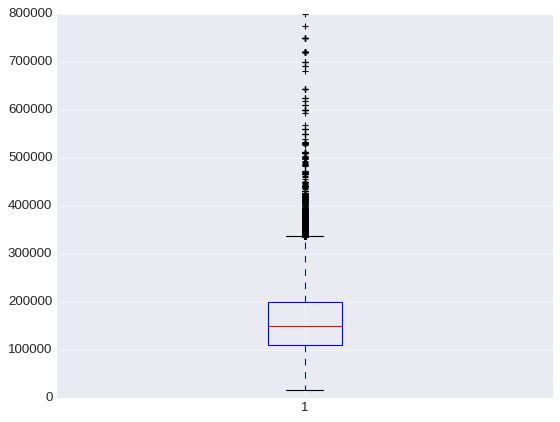

In [26]:
plt.boxplot(df['salary_in_usd'])

In [27]:
df['salary_in_usd'] = pd.to_numeric(df['salary_in_usd'], errors='coerce')
Q1 = df['salary_in_usd'].quantile(0.25)
Q3 = df['salary_in_usd'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['salary_in_usd'] = df['salary_in_usd'].clip(lower=lower_bound, upper=upper_bound)

{'whiskers': [<matplotlib.lines.Line2D at 0x7c87bed08b50>,
 'caps': [<matplotlib.lines.Line2D at 0x7c87bed10c50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c87bed086d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7c87bed12a10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7c87bed1bf10>],
 'means': []}

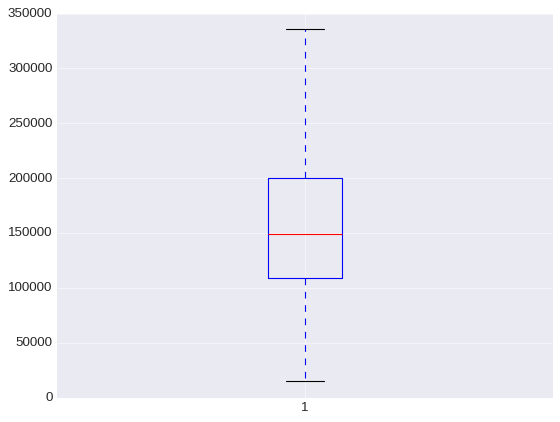

In [28]:
plt.boxplot(df['salary_in_usd'])

# Plotting Salary Distribution

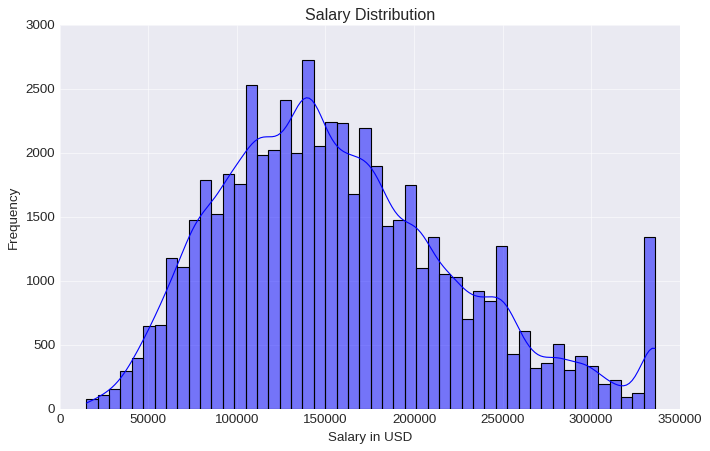

In [29]:
plt.figure(figsize = (10,6))
sns.histplot(df['salary_in_usd'], bins = 50 , kde = True)
plt.title("Salary Distribution")
plt.xlabel("Salary in USD")
plt.ylabel("Frequency")
plt.show()

# Log Transformation

## Since the salaries skew we are applying log transformation to make sure that the salary distribution is balanced

In [30]:
df['log_salary'] = np.log1p(df['salary_in_usd'])

Text(0, 0.5, 'Frequency')

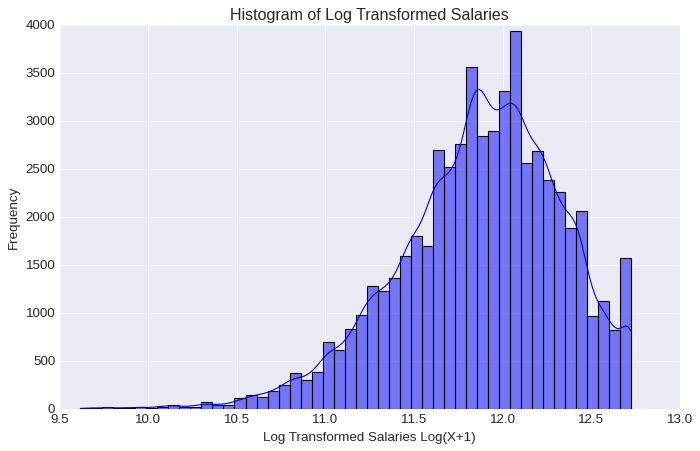

In [31]:
plt.figure(figsize = (10,6))
sns.histplot(df['log_salary'], bins = 50, kde = True)
plt.title("Histogram of Log Transformed Salaries")
plt.xlabel("Log Transformed Salaries Log(X+1)")
plt.ylabel("Frequency")

## Plotting Categorical Feature Distributions
Here we use countplot because we need to check the categorical distribution not the numerical one , earlier we used histplot to represent what salaries lie within high or low frequency ranges
But here we need to find the number of times a categorical string occurs in the data. Therefore we use countplot to

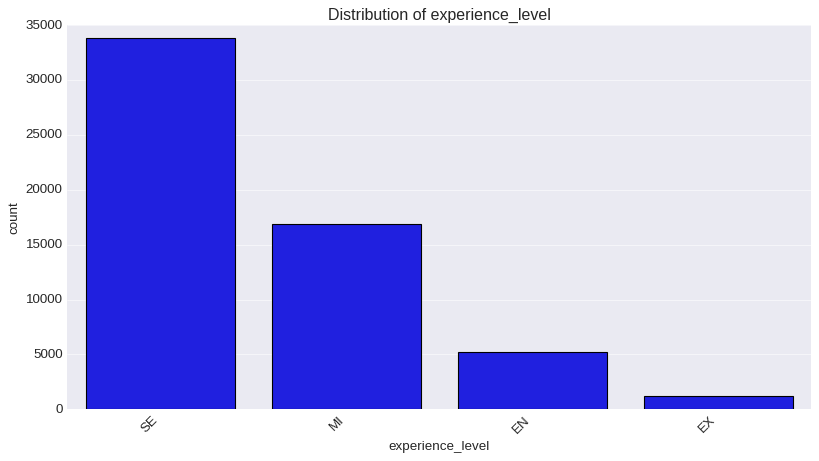

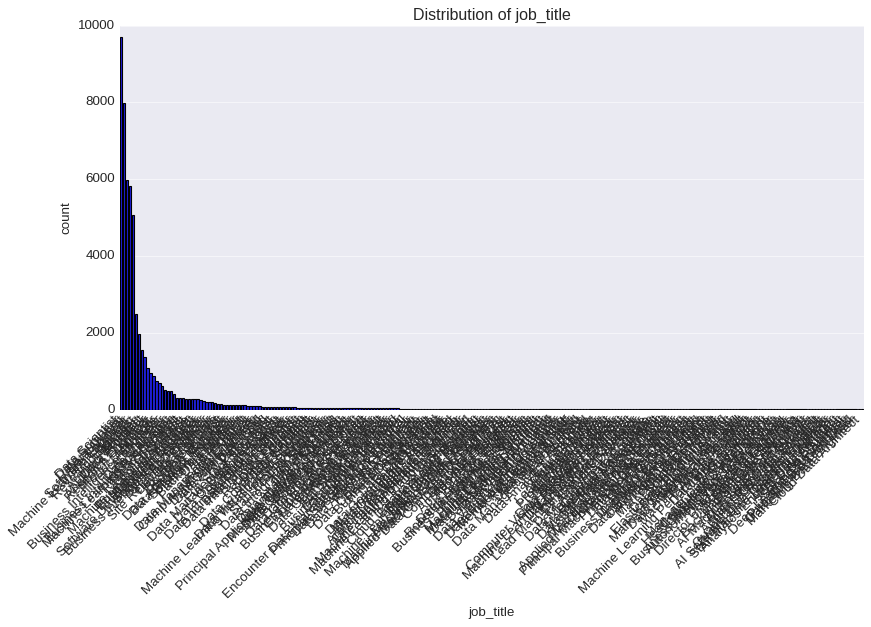

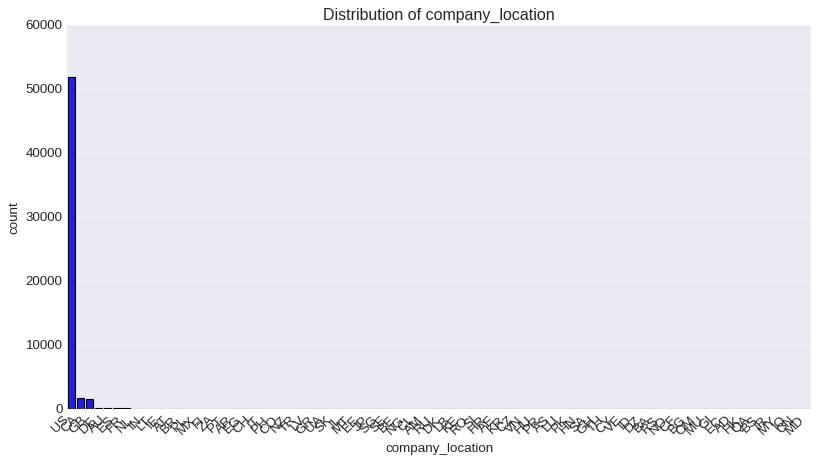

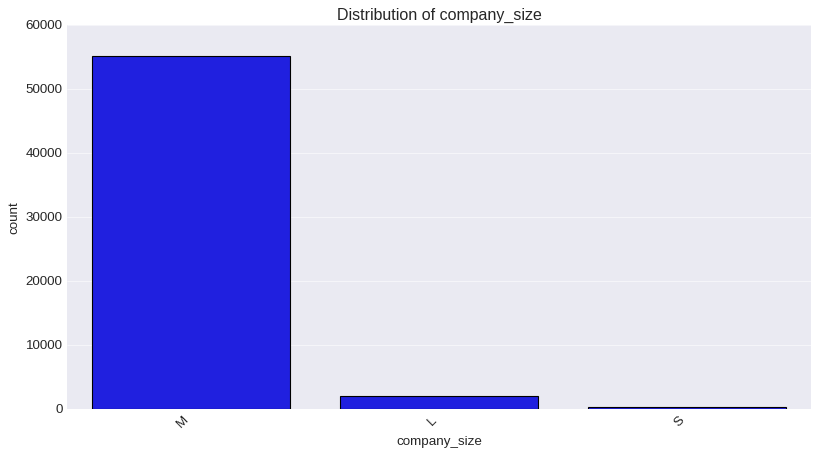

In [32]:
categorical_columns = ['experience_level', 'job_title', 'company_location', 'company_size']
for col in categorical_columns:
    plt.figure(figsize = (12,6))
    sns.countplot(data = df, x = col, order =df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation = 45, ha = 'right')
    plt.show()

## Grouping Rare Job Titles
We need to group the job titles which occur less frequently, into one as they act as a skewing factor to the dataset's distribution
This skewness introduces bias to the dataset and thus, it is highly recommended to dilute the dataset and make a balanced distribution.

### Grouping **Rare Job_Titles** to Other

In [33]:
job_title_counts = df['job_title'].value_counts()
#df['job_title'] = df['job_title'].apply(lambda x: x if job_title_counts[x] > 100 else 'Other')

### Grouping Rare **Company_Locations** to Other

In [34]:
location_counts = df['company_location'].value_counts()
df['company_location'] = df['company_location'].apply(lambda x: x if location_counts[x] > 10 else 'Other')
df['is_US'] = (df['company_location'] == 'US').astype(int)
job_title_counts = df['job_title'].value_counts()
df['job_title_frequency'] = df['job_title'].map(job_title_counts)
df['experience_job_interaction'] = df['experience_level'] + '_' + df['job_title']

# Defining Features and Target

In [35]:
X = df[['experience_level', 'job_title', 'company_location', 'company_size', 'remote_ratio', 'work_year', 'is_US', 'job_title_frequency', 'experience_job_interaction']]
y = df['log_salary']

# Splitting Data into Training and Test Sets

In [36]:
X_train, X_test, y_train , y_test = train_test_split(X,y, test_size = 0.2 , random_state = 42)

# Applying Smoothed Target Encoding

In [37]:
target_enc = TargetEncoder(cols=['job_title', 'company_location', 'experience_job_interaction'], smoothing=10)
target_enc.fit(X_train[['job_title', 'company_location', 'experience_job_interaction']], y_train)
X_train[['job_title', 'company_location', 'experience_job_interaction']] = target_enc.transform(X_train[['job_title', 'company_location', 'experience_job_interaction']])
X_test[['job_title', 'company_location', 'experience_job_interaction']] = target_enc.transform(X_test[['job_title', 'company_location', 'experience_job_interaction']])

# Creating Data Preprocessing Pipeline

In [38]:
categorical_cols = ['experience_level', 'company_size']
numerical_cols = ['job_title', 'company_location', 'remote_ratio', 'work_year', 'is_US', 'job_title_frequency', 'experience_job_interaction']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', Pipeline(steps=[('poly', PolynomialFeatures(degree=2, include_bias=False)), ('scaler', StandardScaler())]), numerical_cols)
    ]
)

# Model Training and Evaluation

In [41]:
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
rf_param_grid = {
    'regressor__n_estimators': [200,300],
    'regressor__max_depth': [20, 30],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
param_list = list(ParameterGrid(rf_param_grid))
# Custom progress tracking with tqdm
with tqdm(total=len(param_list) * 5, desc="Random Forest GridSearchCV") as pbar:  # 5 folds
    rf_grid_search.fit(X_train, y_train)
    pbar.update(len(param_list) * 5)  # Update after all folds
print("Best parameters for RandomForest:", rf_grid_search.best_params_)
print("Best RMSE for RandomForest (negative MSE converted):", np.sqrt(-rf_grid_search.best_score_))
best_rf_model = rf_grid_search.best_estimator_

Random Forest GridSearchCV:   0%|          | 0/80 [00:00<?, ?it/s]

Fitting 5 folds for each of 16 candidates, totalling 80 fits


Random Forest GridSearchCV: 100%|██████████| 80/80 [43:23<00:00, 32.55s/it]

Best parameters for RandomForest: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 300}
Best RMSE for RandomForest (negative MSE converted): 0.35674615609100085


In [42]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from tqdm import tqdm
import numpy as np


xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

xgb_param_grid = {
    'regressor__n_estimators': [300, 400, 500],
    'regressor__learning_rate': [0.05, 0.075],
    'regressor__max_depth': [5],
    'regressor__subsample': [0.8],
    'regressor__colsample_bytree': [0.8]
}

# Define GridSearchCV properly
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1  # This shows progress in console
)

# Optional: tqdm just to visualize total combinations
param_list = list(ParameterGrid(xgb_param_grid))
with tqdm(total=len(param_list), desc="XGBoost GridSearchCV") as pbar:
    xgb_grid_search.fit(X_train, y_train)
    pbar.update(len(param_list))  # After fit completes

# Output best results
print("Best parameters for XGBoost:", xgb_grid_search.best_params_)
print("Best RMSE for XGBoost:", np.sqrt(-xgb_grid_search.best_score_))

best_xgb_model = xgb_grid_search.best_estimator_


XGBoost GridSearchCV:   0%|          | 0/6 [00:00<?, ?it/s]

Fitting 5 folds for each of 6 candidates, totalling 30 fits


XGBoost GridSearchCV: 100%|██████████| 6/6 [00:54<00:00,  9.13s/it]

Best parameters for XGBoost: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 400, 'regressor__subsample': 0.8}
Best RMSE for XGBoost: 0.35491897391708965


In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
models = {
    'Random Forest': best_rf_model,
    'XGBoost' : best_xgb_model,
    'Linear Regression' : Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'Support Vector Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', SVR())

    ])
}

In [44]:
results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1)
    rmse_scores = np.sqrt(-cv_scores)
    results[name] = rmse_scores.mean()
    print(f"{name} -Mean CV RMSE: {rmse_scores.mean():.2f} (+/-{rmse_scores.std()*2:.2f}")

best_model_name = min(results, key = results.get)
best_model = models[best_model_name]
print(f"\nBest model : {best_model_name} with mean CV RMSE: {results[best_model_name]:.2f}")

Random Forest -Mean CV RMSE: 0.36 (+/-0.01
XGBoost -Mean CV RMSE: 0.35 (+/-0.01
Linear Regression -Mean CV RMSE: 0.36 (+/-0.01
Support Vector Regression -Mean CV RMSE: 0.36 (+/-0.01

Best model : XGBoost with mean CV RMSE: 0.35


In [ ]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

## Model Evaluation

In [ ]:
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mean_salary = np.mean(df['salary_in_usd'])
relative_mae = mae / mean_salary * 100

print(f"The mean absolute Error is : {mae:0.2f}")
print(f"The root mean squared error is : {rmse: 0.2f}")
print(f"Relative MAE: {relative_mae:.2f}% (based on mean salary ${mean_salary:.2f})")
print("\nThe first 10 predictions v/s actual values")
print(pd.DataFrame({'Actual' : y_test_original[:10] ,'Predicted': y_pred_original[:10]}))

The mean absolute Error is : 43131.59
The root mean squared error is :  55905.85
Relative MAE: 27.31% (based on mean salary $157938.59)

The first 10 predictions v/s actual values
         Actual      Predicted
23747  202300.0  174419.843750
36140  197866.0  203657.781250
224    262100.0  192414.578125
33250  124000.0  139810.328125
56361  102663.0  114775.117188
30719  302900.0  156878.156250
22903   75000.0   86573.289062
51959  205600.0  154241.812500
30021  148000.0  192399.343750
38340   90000.0  126694.304688


# Visualization of the First 10 results wrt to the Actual Values

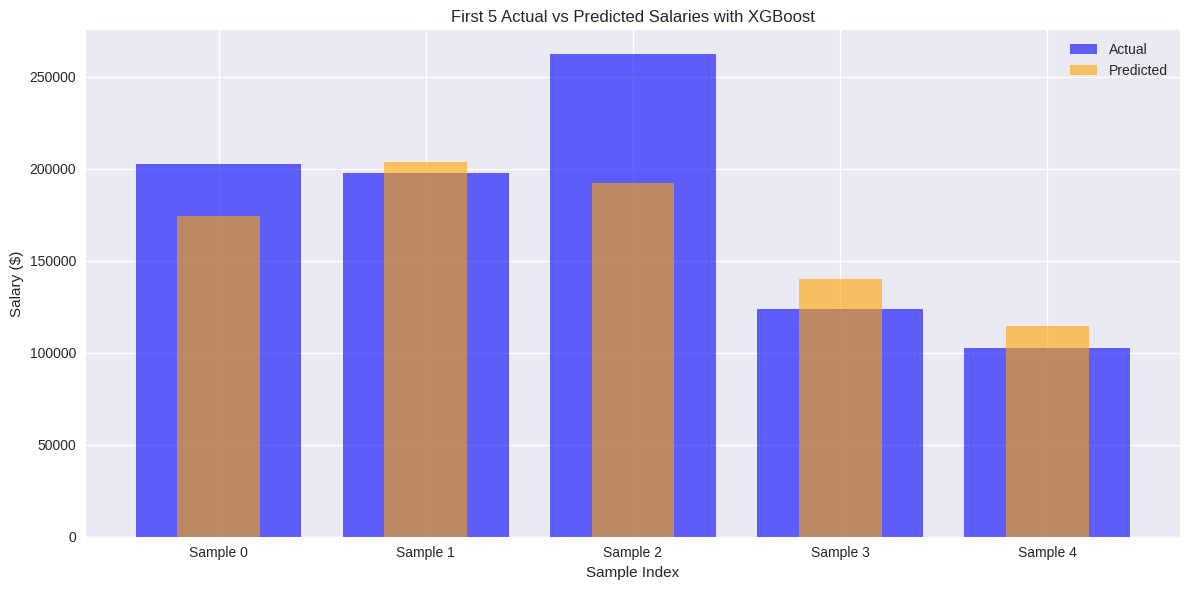

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar([f"Sample {i}" for i in range(5)], y_test_original[:5], color='blue', alpha=0.6, label='Actual')
plt.bar([f"Sample {i}" for i in range(5)], y_pred_original[:5], color='orange', alpha=0.6, label='Predicted', width=0.4, align='center')
plt.title(f"First 5 Actual vs Predicted Salaries with {best_model_name}")
plt.xlabel("Sample Index")
plt.ylabel("Salary ($)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
!pip install category_encoders xgboost shap

Number of features in X_test_transformed: 42
Length of feature_names: 42
SHAP Values Shape: (11439, 42)


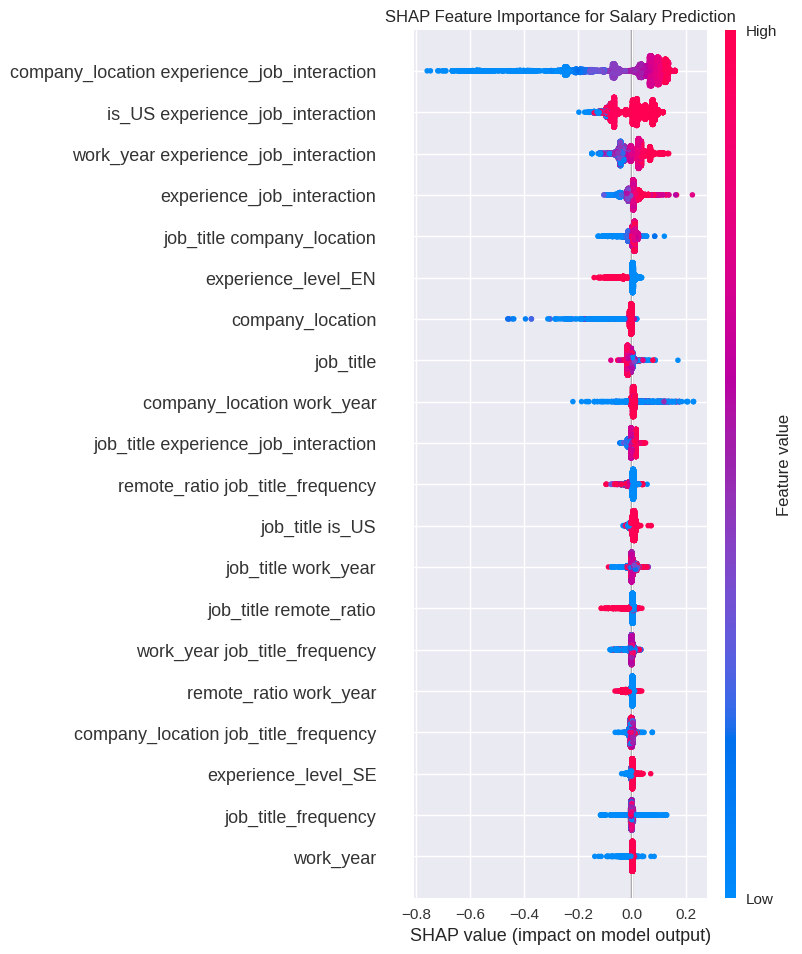

In [ ]:
if best_model_name in ['Random Forest', 'XGBoost']:
    # Transform X_test using the pipeline's preprocessor
    X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

    # Extract feature names after one-hot encoding and polynomial features
    cat_feature_names = list(best_model.named_steps['preprocessor'].named_transformers_['cat']
                            .get_feature_names_out(categorical_cols))
    num_feature_names = numerical_cols
    poly = best_model.named_steps['preprocessor'].named_transformers_['num'].named_steps['poly']
    poly_feature_names = poly.get_feature_names_out(num_feature_names)
    feature_names = cat_feature_names + list(poly_feature_names)

    # Debug: Check feature counts
    print("Number of features in X_test_transformed:", X_test_transformed.shape[1])
    print("Length of feature_names:", len(feature_names))

    # Initialize explainer with the regressor
    explainer = shap.TreeExplainer(best_model.named_steps['regressor'])
    shap_values = explainer.shap_values(X_test_transformed)

    # Debug: Check shap_values structure
    print("SHAP Values Shape:", np.array(shap_values).shape if shap_values is not None else "None")

    # Ensure shap_values is a list or array for regression
    if isinstance(shap_values, list) and len(shap_values) > 0:
        shap_values = shap_values[0]  # Take the first (and only) output for regression

    # Create SHAP summary plot
    if shap_values is not None and len(shap_values) > 0 and len(feature_names) == X_test_transformed.shape[1]:
        shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show=False)
        plt.title('SHAP Feature Importance for Salary Prediction')
        plt.show()
    else:
        print("Warning: Feature names length does not match X_test_transformed columns. Expected", X_test_transformed.shape[1], "but got", len(feature_names))

# Making a StreamLit App

In [7]:
!pip install pyngrok -q

In [8]:
!pip install streamlit

In [1]:
# Create the Streamlit app file with a sidebar
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import plotly.express as px
import sys

# Debug function to print to Streamlit
def debug(message):
    st.write(f"DEBUG: {message}")

# Load and preprocess data
try:
    debug("Loading salaries.json...")
    # Try multiple possible paths
    data_paths = ["/content/salaries.json", "salaries.json", "./salaries.json"]
    df = None

    for path in data_paths:
        try:
            df = pd.read_json(path)
            debug(f"Successfully loaded from {path}")
            break
        except:
            continue

    if df is None:
        st.error("Could not find salaries.json file in any expected location")
        st.stop()

    debug(f"Loaded dataframe with {len(df)} rows.")
    df['salary_in_usd'] = pd.to_numeric(df['salary_in_usd'], errors='coerce')
    df = df.dropna()
    debug(f"After dropping NaN, {len(df)} rows remain.")
    df['is_US'] = (df['company_location'] == 'US').astype(int)
    df['job_title_frequency'] = df['job_title'].map(df['job_title'].value_counts())
    df['experience_job_interaction'] = df['experience_level'].astype('category').cat.codes * df['job_title_frequency']
except Exception as e:
    st.error(f"Error loading data: {e}")
    st.stop()

# Define features and target
X = df[['experience_level', 'job_title', 'company_location', 'company_size', 'remote_ratio', 'work_year', 'is_US', 'job_title_frequency', 'experience_job_interaction']]
y = df['salary_in_usd']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and fit the preprocessor
try:
    categorical_features = ['experience_level', 'job_title', 'company_location', 'company_size']
    numeric_features = ['remote_ratio', 'work_year', 'is_US', 'job_title_frequency', 'experience_job_interaction']
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features),
            ('num', StandardScaler(), numeric_features)
        ]
    )
    preprocessor.fit(X_train)
    debug("Preprocessor fitted successfully.")
except Exception as e:
    st.error(f"Error fitting preprocessor: {e}")
    st.stop()

# Train the model
try:
    # Try XGBoost first, fallback to RandomForest if XGBoost fails
    try:
        from xgboost import XGBRegressor
        use_xgb = True
    except ImportError:
        from sklearn.ensemble import RandomForestRegressor
        use_xgb = False
        debug("XGBoost not available, using RandomForest")

    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV

    if use_xgb:
        xgb_model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', XGBRegressor(random_state=42))
        ])
        xgb_param_grid = {
            'regressor__n_estimators': [300, 400],
            'regressor__learning_rate': [0.05, 0.075],
            'regressor__max_depth': [5],
            'regressor__subsample': [0.8],
            'regressor__colsample_bytree': [0.8]
        }
        xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        xgb_grid_search.fit(X_train, y_train)
        best_xgb_model = xgb_grid_search.best_estimator_
    else:
        # Fallback to RandomForest
        rf_model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(random_state=42, n_estimators=100))
        ])
        rf_model.fit(X_train, y_train)
        best_xgb_model = rf_model

    debug("Model trained successfully.")
except Exception as e:
    st.error(f"Error training model: {e}")
    st.stop()

# Streamlit app
st.title("💰 Salary Prediction App")
st.write("""
This app predicts salary based on job-related features using an XGBoost model.
Explore the data and get personalized predictions!
""")

# Interactive Visualization
st.subheader("Salary Distribution by Experience Level")
fig = px.bar(df, x='experience_level', y='salary_in_usd', color='experience_level',
             title="Average Salary by Experience Level", height=400)
st.plotly_chart(fig)

# Sidebar for secondary inputs
with st.sidebar:
    st.header("Settings")
    company_size = st.selectbox("Company Size", ['S', 'M', 'L'], key="co_size")
    company_location = st.selectbox("Company Location", df['company_location'].unique().tolist(), key="loc")
    st.write("Adjust these to filter your context!")

# Main area for primary inputs
st.subheader("Enter Your Details")
col1, col2 = st.columns(2)

with col1:
    experience_level = st.selectbox("Experience Level", ['EN', 'MI', 'SE', 'EX'], key="exp_level")
    job_title = st.selectbox("Job Title", df['job_title'].unique().tolist(), key="job_title")

with col2:
    remote_ratio = st.slider("Remote Ratio (%)", 0, 100, 50, key="remote")
    work_year = st.slider("Work Year", 2020, 2025, 2023, key="year")

# Additional interactive controls
is_US = st.checkbox("Is Company in US?", key="us_check")
sensitivity = st.slider("Prediction Sensitivity (0.8 to 1.2)", 0.8, 1.2, 1.0, 0.1, key="sensitivity",
                       help="Adjust this to scale the prediction up or down.")

# Dynamic feedback
st.write(f"Current Selection: Experience Level = {experience_level}, Remote Ratio = {remote_ratio}%")

# Create input data frame
try:
    input_data = pd.DataFrame({
        'experience_level': [experience_level],
        'job_title': [job_title],
        'company_location': [company_location],
        'company_size': [company_size],
        'remote_ratio': [remote_ratio],
        'work_year': [work_year],
        'is_US': [1 if is_US else 0],
        'job_title_frequency': [df['job_title'].value_counts().get(job_title, 1)],
        'experience_job_interaction': [dict(zip(df['experience_level'], range(len(df['experience_level'].unique())))).get(experience_level, 0) * df['job_title'].value_counts().get(job_title, 1)]
    })
    debug("Input data frame created.")
except Exception as e:
    st.error(f"Error creating input data: {e}")
    st.stop()

# Predict
if st.button("Predict Salary", key="predict_btn"):
    try:
        prediction = best_xgb_model.predict(input_data) * sensitivity
        st.success(f"Predicted Salary: ${prediction[0]:,.2f}")
        st.write("Note: This prediction is adjusted by the sensitivity factor.")
        debug("Prediction successful.")
    except Exception as e:
        st.error(f"Error making prediction: {e}")

# Add a feedback section
st.subheader("Your Feedback")
feedback = st.text_area("How can we improve this app?", key="feedback")
if st.button("Submit Feedback", key="submit_feedback"):
    st.write("Thank you for your feedback!")
    debug("Feedback submitted.")

Writing app.py


In [ ]:
# Install required packages
!pip install -q streamlit pyngrok xgboost

# Set ngrok authtoken
!ngrok authtoken 2pu51TcTmLYDUdZ9qP9gaCXXbkP_67JJGsJHnvLBREHqgvLBL

# Run Streamlit in the background
import subprocess
import time
import os

print("🚀 Starting Streamlit application...")

# Kill any existing streamlit processes
try:
    subprocess.run(['pkill', '-f', 'streamlit'], capture_output=True)
    time.sleep(2)
except:
    pass

# Start Streamlit process with better error handling
streamlit_process = subprocess.Popen(
    ['streamlit', 'run', '/content/app.py', '--server.port', '8501', '--server.address', '0.0.0.0', '--server.headless', 'true'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True,
    bufsize=1
)

# Wait for Streamlit to start
print("⏳ Waiting for Streamlit to initialize...")
time.sleep(15)

# Check if process is running
if streamlit_process.poll() is None:
    print("✅ Streamlit process is running successfully!")
else:
    print("❌ Streamlit failed to start. Checking logs...")
    stdout, stderr = streamlit_process.communicate()
    if stdout:
        print("STDOUT:", stdout)
    if stderr:
        print("STDERR:", stderr)
    exit()

print("🔗 Starting ngrok tunnel...")

# Start ngrok tunnel
try:
    from pyngrok import ngrok

    # Kill existing tunnels
    ngrok.kill()
    time.sleep(2)

    # Create new tunnel
    public_url = ngrok.connect(8501)
    print(f"🌐 Streamlit app is live at: {public_url}")
    print("=" * 60)
    print("✅ SUCCESS! Your app is now running!")
    print("=" * 60)

except Exception as e:
    print(f"❌ Error starting ngrok: {e}")
    streamlit_process.terminate()
    exit()

# Keep the process running and show logs
print("📊 Application logs (Press Runtime -> Interrupt to stop):")
print("-" * 60)

try:
    while streamlit_process.poll() is None:
        # Read stdout
        if streamlit_process.stdout.readable():
            line = streamlit_process.stdout.readline()
            if line:
                print("STDOUT:", line.strip())

        # Read stderr
        if streamlit_process.stderr.readable():
            line = streamlit_process.stderr.readline()
            if line:
                print("STDERR:", line.strip())

        time.sleep(1)

except KeyboardInterrupt:
    print("\n🛑 Stopping application...")
    streamlit_process.terminate()
    ngrok.kill()
    print("✅ Application stopped successfully")
except Exception as e:
    print(f"\n❌ Error occurred: {e}")
    streamlit_process.terminate()
    ngrok.kill()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.0 MB/s eta 0:00:00
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
🚀 Starting Streamlit application...
⏳ Waiting for Streamlit to initialize...
✅ Streamlit process is running successfully!
🔗 Starting ngrok tunnel...
🌐 Streamlit app is live at: NgrokTunnel: "https://9e97133abd46.ngrok-free.app" -> "http://localhost:8501"
✅ SUCCESS! Your app is now running!
📊 Application logs (Press Runtime -> Interrupt to stop):
------------------------------------------------------------
STDOUT: 
STDERR: /usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encode

In [ ]:
n